In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
%matplotlib inline

# Subduction zone thermal models
Importing the subduction zone thermal models database from Syracuse, E. M., van Keken, P. E. & Abers, G. A. (2010). The global range of subduction zone thermal models. Physics of the Earth and Planetary Interiors 183, 73–90. The thermal model used is the **D80** in which the boundary between partial and full coupling set at 80 km depth (2.6 GPa). Note there is a typo in the original Lon(º) data in Table 2 for Central and North Cascadia, it should read in negative values.

Length of individual subduction zones are taken from Van Keken, P. E., Hacker, B. R., Syracuse, E. M. & Abers, G. A. (2011). Subduction factory: 4. Depth-dependent flux of H2O from subducting slabs worldwide. Journal of Geophysical Research: Solid Earth. Blackwell Publishing Ltd 116, B01401.

The added extra columns are the temperature and pressure conditions for serpentinite dehydration computed by finding the intersection of the slab surface and slab Moho PT-path and the PT-parametrized serpentinite dehydration reaction as described my Menzel, M. D., Garrido, C. J. & López Sánchez-Vizcaíno, V. (2020). Fluid-mediated carbon release from serpentinite-hosted carbonates during dehydration of antigorite-serpentinite in subduction zones. Earth and Planetary Science Letters. Elsevier B.V. 531, 115964. 

The parametrization of the serpentinite dehydration reaction has been recalibrated to match the serpentinite sample used in this studied (sample Al98-05a, Extended Data Table 1) and the takes into accound the EoS used in this work (PSEoS instead of the CORK EoS used by Menzel et al., 2020). 


In [2]:
file_name  = 'data/Syracuse_et_al_Thermal_models.csv'
# Subduction zone database (D80 model from Syracuse et al., 2010 PEPI)
SZ_DB    = pd.read_csv(file_name, delimiter=',', skiprows=0)

In [3]:
SZ_DB.head()

,Name,Lon (°),Lat (°),H (km),Arc-trench distance (km),Length (km),Slab dip (°),Vc (km/Ma),Age (Ma),Descent rate (km/Ma),...,Sediment thickness (km),Subducted sediment thickness (km),Upper plate type,Upper plate thickness (km),Upper plate age (Ma),φ (km) calculated,Serpentine dehydration Slab Surface T (ºC),Serpentine dehydration Slab Surface P (GPa),Serpentine dehydration Moho depth T (ºC),Serpentine dehydration Moho depth P (GPa)
0,Central Cascadia,-122.0,47.0,90.0,305.0,450,19.8,30.0,6.9,14.2,...,2.0,0.4,Continental,40.0,NaN,70,658,2.41,655,2.64
1,North Cascadia,-121.5,42.0,100.0,345.0,500,22.4,40.0,10.6,12.1,...,2.0,0.4,Continental,35.0,NaN,162,659,2.38,656,2.57
2,Northern Peru Gap,-79.0,-6.8,NaN,NaN,500,10.2,69.5,29.0,12.3,...,0.7,0.4,Continental,50.0,NaN,357,654,2.72,642,3.31
3,Mexico,-99.5,19.1,80.0,360.0,1350,59.5,47.0,10.0,40.5,...,0.6,0.3,Continental,45.0,NaN,405,659,2.34,654,2.69
4,Colombia/Ecuador,-77.5,0.0,155.0,305.0,900,28.0,60.0,15.0,28.2,...,1.8,0.3,Continental,50.0,NaN,423,654,2.69,636,3.52


# Global distribution of any entry of the thermal model database

Any of the entries in the database base can be geographically plotted using the Canopy python package 

[![DOI:10.1101/2021.01.08.425840](http://img.shields.io/badge/DOI-10.1101/2021.01.08.425840-B31B1B.svg)](https://zenodo.org/record/5842769#.YpjL5C0rxo4) 


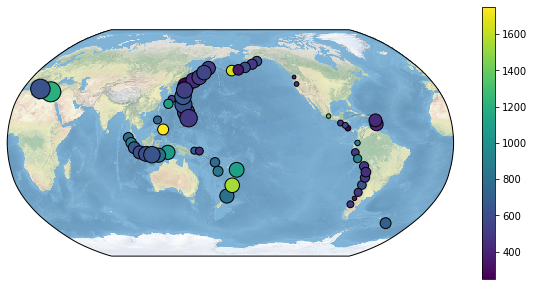

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-180, globe=None))
ax.stock_img()

cm = plt.cm.get_cmap('viridis')

cb = ax.scatter(x = SZ_DB['Lon (°)'].values,
                y = SZ_DB['Lat (°)'].values,
                c = SZ_DB['Length (km)'].values,
                s = 2*SZ_DB['Age (Ma)'].values,
                edgecolor='black',
                cmap=cm, transform=ccrs.PlateCarree())

plt.colorbar(cb, cmap=cm, orientation='vertical',ticklocation='auto')
plt.show()

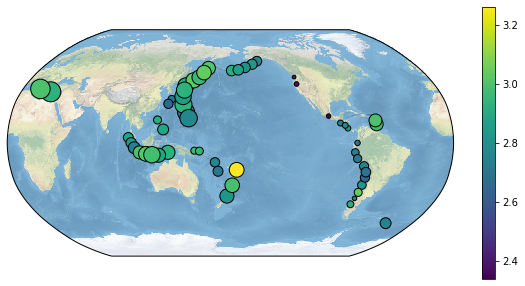

In [5]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-180, globe=None))
ax.stock_img()

cm = plt.cm.get_cmap('viridis')

cb = ax.scatter(x = SZ_DB['Lon (°)'].values,
                y = SZ_DB['Lat (°)'].values,
                c = SZ_DB['Serpentine dehydration Slab Surface P (GPa)'].values,
                s = 2*SZ_DB['Age (Ma)'].values,
                edgecolor='black',
                cmap=cm, transform=ccrs.PlateCarree())

plt.colorbar(cb, cmap=cm, orientation='vertical',ticklocation='auto')
plt.show()

# Intrinsic serpentinite dehydration
The following cell takes the oxygen chemical potential from a werami output in .tab form and compute the oxygen fugacity using the chemical potential of oxygen at 1 bar. It does the same for the FMQ buffer and express the relative difference between the serpentinite and the FMQ buffer.

In [6]:
#%% Serpentinite sample (Al98-05a)
file_1 = 'data/serpentinite_muO2.tab' # File (.tab from werami) containing the P(bar) T(K) mu[O2],J/mol from a pseudosection
file_2 = 'data/o2_1bar.tab'           # mu[O2],J/mol at 1 bar and range of temperatures
file_3 = 'data/qfm.tab'               # mu[O2],J/mol for QFM at PT from a psudosection with pure quartz-fayalite-magnetite

# Size of the file
header  = pd.read_csv(file_1, delimiter='\s+', nrows=11)
[initial_x, nodes_x, interval_x] = [float(header.iloc[3]), int(header.iloc[5]), float(header.iloc[4])]
[initial_y, nodes_y, interval_y] = [float(header.iloc[7]), int(header.iloc[9]), float(header.iloc[8])]

# setting x and y scales
T   = np.linspace(initial_x, initial_x + np.round(interval_x*(nodes_y-1)), nodes_x)
P   = np.linspace(initial_y, initial_y + np.round(interval_y*(nodes_x-1)), nodes_y)

# importing O2 chemical potential data
df        = pd.read_csv(file_1,delimiter='\s+',skiprows = 12)
# importing O2 chemical potential at 1 bar
O2_1bar   = pd.read_csv(file_2,delimiter='\s+',skiprows = 12, usecols=["mu[O2],J/mol"])
# importing O2 chemical potential for the assemblage forsterite-magnetite-quartz
muO2_fmq  = pd.read_csv(file_3,delimiter='\s+',skiprows = 12, usecols=["mu[O2],J/mol"]) 

# Adding to the main dataframe by repeating number of nodes_x and 
df['mu_o2_1bar'] = pd.concat([O2_1bar]*nodes_x, ignore_index=True)
df['fmq']        = muO2_fmq['mu[O2],J/mol']

# Oxygen fugacity for the sample
df['fO2']     = ((df['mu[O2],J/mol']-df['mu_o2_1bar'])/8.314462618/df['T(K)'])/np.log(10)
# Oxygen fugacity for the FMQ buffer
df['fO2_FMQ'] = ((df['fmq']-df['mu_o2_1bar'])/8.314462618/df['T(K)'])/np.log(10)
# Delta oxygen fugacity relative to the FMQ buffer
df['deltafO2_FMQ'] = df['fO2']-df['fO2_FMQ']

# Resizing to make a matrix using nodes_x and nodes_y for plotting purposes
fO2             = df.pivot(index='P(bar)', columns='T(K)', values='fO2')
fO2_FMQ         = df.pivot(index='P(bar)', columns='T(K)', values='fO2_FMQ')

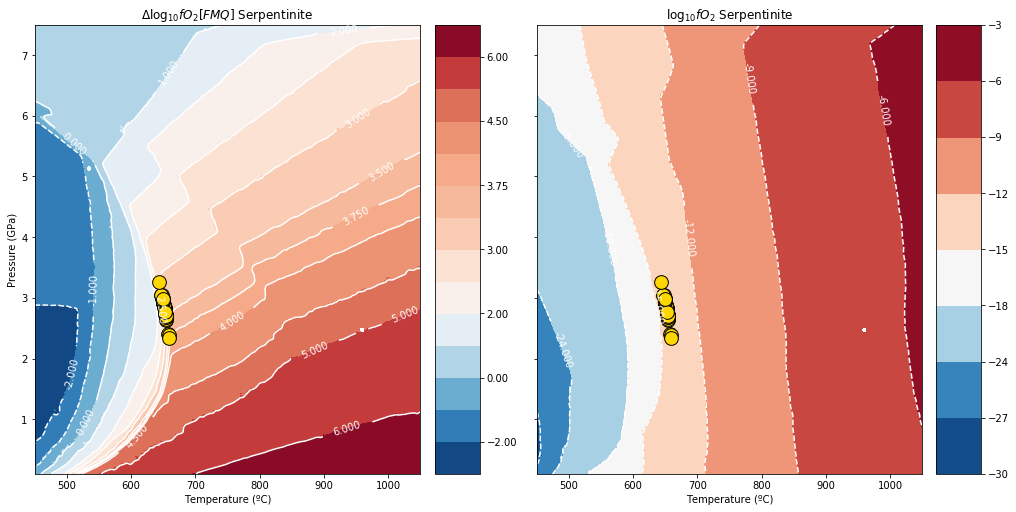

In [7]:
# %% FIGURE %% 
from scipy.ndimage.filters import gaussian_filter
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(14,7), sharey=True)

levels1 = [-3, -2, -1, 0, 1, 2, 2.5, 3, 3.5, 3.75, 4, 4.5, 5, 6, 7]
CS1 = ax1.contourf(T-273.15, P/10000, gaussian_filter(fO2-fO2_FMQ,0.2), levels1, cmap='RdBu_r')
ax1.scatter(SZ_DB['Serpentine dehydration Slab Surface T (ºC)'].values, SZ_DB['Serpentine dehydration Slab Surface P (GPa)'].values, c='gold', s=188, edgecolors='black', zorder=3)
plt.colorbar(CS1,ax=ax1)

CS1 = ax1.contour(T-273.15, P/10000, gaussian_filter(fO2-fO2_FMQ, 1), levels1, colors = 'white' , zorder=1)
ax1.clabel(CS1, inline=0.5, fontsize=10)

ax1.set_title('$\Delta \log_{10}fO_2[FMQ]$ Serpentinite')
ax1.set_xlabel('Temperature (ºC)')
ax1.set_ylabel('Pressure (GPa)')

#################################### RIGHT ############# 

levels2 = [-30, -27, -24, -18, -15, -12, -9, -6, -3]
CS2 = ax2.contourf(T-273.15, P/10000, gaussian_filter(fO2,0.2), levels2, cmap='RdBu_r')
ax2.scatter(SZ_DB['Serpentine dehydration Slab Surface T (ºC)'].values, SZ_DB['Serpentine dehydration Slab Surface P (GPa)'].values, c='gold', s=188, edgecolors='black', zorder=3)
plt.colorbar(CS2,ax=ax2)

CS2 = ax2.contour(T-273.15, P/10000, gaussian_filter(fO2, 1), levels2, colors = 'white' , zorder=1)
ax2.clabel(CS2, inline=0.5, fontsize=10)

ax2.set_title('$\log_{10}fO_2$ Serpentinite')
ax2.set_xlabel('Temperature (ºC)')

plt.show()
#plt.savefig('Serpentinite_DeltafO2.pdf')

# Global distribution of $\Delta \log_{10,FMQ} fO_2$ at the slab surface serpentinite
The following cell interporate the oxygen fugacity values from the pseudosection into the PT conditions of dehydration of all subduction zone thermal models (slab surface).

In [8]:
from scipy.interpolate import griddata

# PT conditions of serpentinite dehydration from the global thermal models of Syracuse et al. see above
PT_szDB    = np.array([SZ_DB['Serpentine dehydration Slab Surface T (ºC)'].values,
                      SZ_DB['Serpentine dehydration Slab Surface P (GPa)'].values*10000]).T
# PT conditions from the pseudosection and delta logfO2,[FMQ] for the serpentinite
PT         = np.array([df['T(K)'].values-273, df['P(bar)'].values]).T
values_fo2 = np.array(df['deltafO2_FMQ'].values)

# Interpolated values of delta logfO2,[FMQ] for the serpentinite at the location of dehydration
deltafO2_PT_intr   = griddata(PT, values_fo2, PT_szDB, method='nearest')
SZ_DB['deltafO2_intr'] = pd.DataFrame(deltafO2_PT_intr)

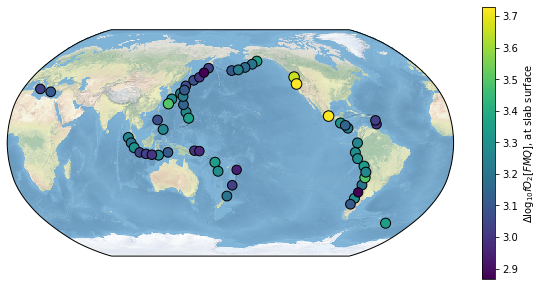

In [9]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=-180, globe=None))
ax.stock_img()

cm = plt.cm.get_cmap('viridis')

cb = ax.scatter(x = SZ_DB['Lon (°)'].values,
                y = SZ_DB['Lat (°)'].values,
                c = SZ_DB['deltafO2_intr'].values,
                s = 30*SZ_DB['deltafO2_intr'].values,
                edgecolor='black',
                cmap=cm, transform=ccrs.PlateCarree())

cbar = plt.colorbar(cb, cmap=cm, orientation='vertical')
cbar.ax.set_ylabel('$\Delta \log_{10} fO_2[FMQ]$, at slab surface')
plt.show()

# Fluid from sediments infiltration models

In [10]:
PT_szDB_barK = np.array([SZ_DB['Serpentine dehydration Slab Surface T (ºC)'].values + 273,
                         SZ_DB['Serpentine dehydration Slab Surface P (GPa)'].values*10000]).T

PT_barK   = np.array([df['T(K)'].values, df['P(bar)'].values]).T

muO2      = griddata(PT_barK, df['mu[O2],J/mol'].values, PT_szDB_barK, method='nearest')
muO2_1bar = griddata(PT_barK, df['mu_o2_1bar'].values,   PT_szDB_barK, method='nearest')
muO2_QFM  = griddata(PT_barK, df['fmq'].values,          PT_szDB_barK, method='nearest')

# function transforming oxygen chemical data into oxygen fugacity
def fO2_mu(muO2, muO2_1bar, T):
    return (muO2-muO2_1bar)/8.314462618/T/np.log(10)

In [11]:
# Color code based on pressure of dehydration at the slab surface
from matplotlib import cm
c = SZ_DB['Serpentine dehydration Slab Surface P (GPa)']
c = cm.jet_r((c-np.min(c))/(np.max(c)-np.min(c)))

In [12]:
# number of iterations to be imported
rows = 220

mu_O2_gloss = pd.DataFrame()
mu_O2_graph = pd.DataFrame()

for i in range(len(SZ_DB)):
    muO2_file_gloss     = pd.read_csv('data/fluids_gloss/mu_O2/PT_inf_gloss' + str(i) + '_1.tab', nrows = rows, skiprows=8, delimiter='\s+')
    mu_O2_gloss[str(i)] = muO2_file_gloss['mu[O2],J/mol']
    muO2_file_graph     = pd.read_csv('data/fluids_graph/mu_O2/PT_inf_graphite' + str(i) + '_1.tab', nrows = rows, skiprows=8, delimiter='\s+')
    mu_O2_graph[str(i)] = muO2_file_graph['mu[O2],J/mol']
    
deltafO2_FMQ_gloss = fO2_mu(mu_O2_gloss, muO2_1bar, PT_szDB_barK[:,0]) - fO2_mu(muO2_QFM, muO2_1bar, PT_szDB_barK[:,0])
deltafO2_FMQ_graph = fO2_mu(mu_O2_graph, muO2_1bar, PT_szDB_barK[:,0]) - fO2_mu(muO2_QFM, muO2_1bar, PT_szDB_barK[:,0])

# moving average to smooth the data
deltafO2_FMQ_gloss = deltafO2_FMQ_gloss.rolling(30, min_periods=1).mean() 
deltafO2_FMQ_graph = deltafO2_FMQ_graph.rolling(30, min_periods=1).mean() 

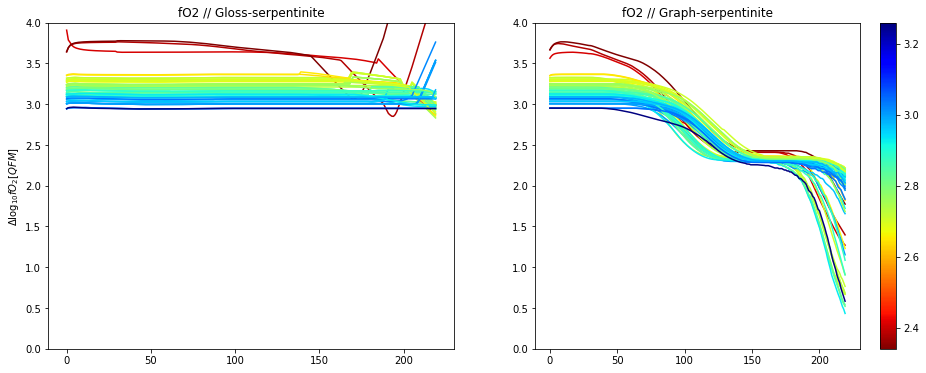

In [13]:


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1 = deltafO2_FMQ_gloss.plot(ax=axes[0], legend = None, color=c, title = 'fO2 // Gloss-serpentinite')
ax2 = deltafO2_FMQ_graph.plot(ax=axes[1], legend = None, color=c, title = 'fO2 // Graph-serpentinite')

ax1.set_ylim(0,4)
ax2.set_ylim(0,4)

ax1.set_ylabel('$\Delta \log_{10} fO_2 [QFM]$')

mycmap = cm.jet_r
sm = plt.cm.ScalarMappable(cmap=mycmap, 
                           norm=plt.cm.colors.Normalize(vmin=np.min(SZ_DB['Serpentine dehydration Slab Surface P (GPa)']), 
                                                        vmax=np.max(SZ_DB['Serpentine dehydration Slab Surface P (GPa)'])))
plt.colorbar(sm)
plt.show()
#fig.savefig('fo2_intraslab.pdf')

# Fluid speciation as a function of fluid sediment infiltration
## Sulphates

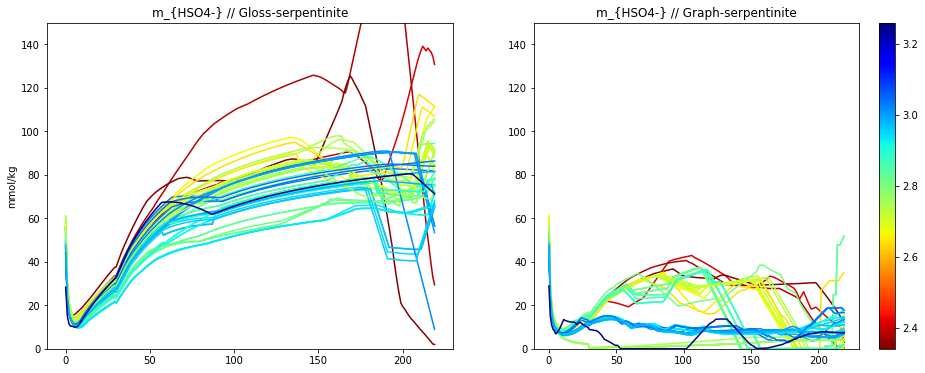

In [14]:
selected_species = 'm_{HSO4-}'

gloss_species = pd.DataFrame()
graph_species = pd.DataFrame()

for i in range(len(SZ_DB)):
    species_file_gloss    = pd.read_csv('data/fluids_gloss/speciation/PT_inf_gloss' + str(i) + '_speciation.tab', nrows = rows, skiprows=8, delimiter='\s+')
    gloss_species[str(i)] = species_file_gloss[selected_species]*1000
    species_file_graph    = pd.read_csv('data/fluids_graph/speciation/PT_inf_graphite' + str(i) + '_speciation.tab', nrows = rows, skiprows=8, delimiter='\s+')
    graph_species[str(i)] = species_file_graph[selected_species]*1000
               
graph_species = graph_species.rolling(30, min_periods=1).mean() 
gloss_species = gloss_species.rolling(30, min_periods=1).mean() 
        
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
gloss_species.plot(ax=axes[0], legend = None, color=c, title = selected_species + ' // Gloss-serpentinite')
graph_species.plot(ax=axes[1], legend = None, color=c, title = selected_species + ' // Graph-serpentinite')

mycmap = cm.jet_r
sm = plt.cm.ScalarMappable(cmap=mycmap, 
                           norm=plt.cm.colors.Normalize(vmin=np.min(SZ_DB['Serpentine dehydration Slab Surface P (GPa)']), 
                                                        vmax=np.max(SZ_DB['Serpentine dehydration Slab Surface P (GPa)'])))
plt.colorbar(sm, orientation='vertical')
axes[0].set_ylim(0,150)
axes[1].set_ylim(0,150)

axes[0].set_ylabel('mmol/kg')

plt.show()
#fig.savefig('m_{HSO4-}_colorbar.pdf')

# Global distribution at the slab surface when infiltrated by sediments with different redox capacity
We proceed equally for the fluid infiltrated cases. (as observed in CdA)
This cell add to the subduction zone thermal model databse (SZ_DB) the columns corresponding to the selected_species (selected columns) from the WERAMI output file. The interaction is determined by the node (at node 120 that equals to 12 mol/kg)

## Intrinsic serpentinite dehydration

In [15]:
file_intrinsic = 'data/fluids_intrinsic/Al98-05a_lagged_3_2_opcion40.tab'
species_intrinsic    = pd.read_csv(file_intrinsic, delimiter='\s+', skiprows=8)

# y_{} are in mol fraction units whereas m_{} are in mol/kg units (molality)
selected_species = ['y_{CO2}',
                    'y_{CH4}',
                    'y_{H2S}',
                    'y_{H2}',
                    'y_{H2O}', 
                    'm_{HSO4-}', 
                    'm_{SO4-2}', 
                    'm_{HS-}', 
                    'm_{HSO3-}', 
                    'm_{MgSO4,aq}', 
                    'm_{CaSO4,aq}', 
                    'm_{SO2,aq}',
                    'm_{H+}',
                    'tot_solute_m']

for i in range(len(selected_species)):
    SZ_DB[selected_species[i] + '_intr'] = species_intrinsic[selected_species[i]].values

## Global distribution of any species from the WERAMI file for given Integrated Fluid Rock Rate (12 mol/kg)

In [16]:
node = 120 # node to be imported corresponding to the maximum interaction observed at CdA = 12 mol fluid/kg of rock
speciation_gloss = pd.DataFrame()
speciation_graph = pd.DataFrame()
species_at_node  = pd.DataFrame()

In [17]:
### Slow execution time expected

species_path_gloss     = 'data/fluids_gloss/speciation/'
species_path_graph     = 'data/fluids_graph/speciation/'

for i in range(len(selected_species)):
    for j in range(len(SZ_DB)):
        species_gloss    = pd.read_csv(species_path_gloss + 'PT_inf_gloss'    + str(j) + '_speciation.tab', 
                                       nrows=151, skiprows=8, delimiter='\s+')
        species_graph    = pd.read_csv(species_path_graph + 'PT_inf_graphite' + str(j) + '_speciation.tab', 
                                       nrows=151, skiprows=8, delimiter='\s+')
        
        species_gloss = species_gloss.rolling(30, min_periods=1).mean() 
        species_graph = species_graph.rolling(30, min_periods=1).mean()       
        
        speciation_gloss[str(j)] = species_gloss[selected_species[i]]
        speciation_graph[str(j)] = species_graph[selected_species[i]]
        
    SZ_DB[selected_species[i] + '_gloss'] = pd.DataFrame(speciation_gloss.loc[node]).values
    SZ_DB[selected_species[i] + '_graph'] = pd.DataFrame(speciation_graph.loc[node]).values
    
SZ_DB['deltafO2_intr']  = pd.DataFrame(deltafO2_PT_intr)
SZ_DB['deltafO2_gloss'] = deltafO2_FMQ_gloss.loc[node].values
SZ_DB['deltafO2_graph'] = deltafO2_FMQ_graph.loc[node].values

## Example of global distribution of $\ce{HSO4-}$

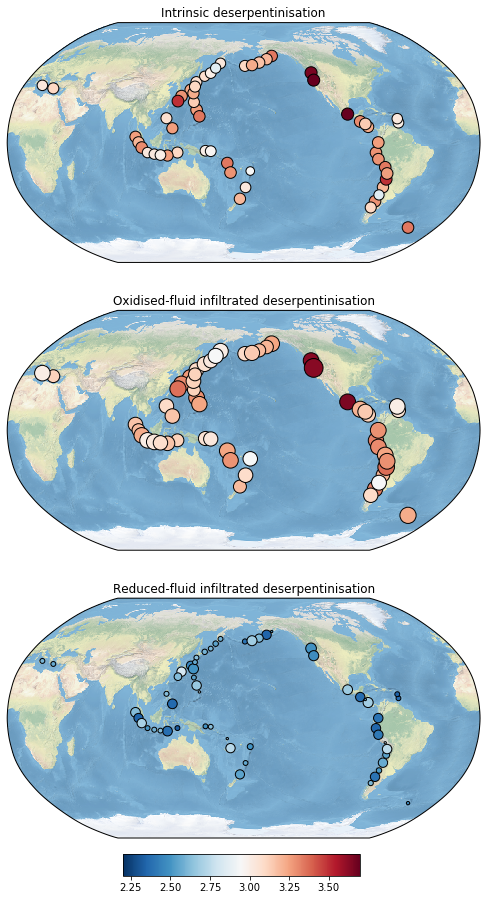

In [18]:
models      = ['intr', 'gloss', 'graph']
model_title = ['Intrinsic deserpentinisation', 
               'Oxidised-fluid infiltrated deserpentinisation', 
               'Reduced-fluid infiltrated deserpentinisation']

nrows, ncols = 3, 1

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=-180, globe=None)},
                        figsize=(11,15))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

cm = plt.cm.get_cmap('RdBu_r')

#Loop over all of the models
for i,model in enumerate(models):
    
        # 
        axs[i].stock_img()

        # Scatter plot
        cs=axs[i].scatter(x = SZ_DB['Lon (°)'].values,
                          y = SZ_DB['Lat (°)'].values,
                          c = SZ_DB['deltafO2_' + models[i]].values,
                          vmin=2.2, vmax=3.7, 
                          s = 3000*SZ_DB['m_{HSO4-}_' + models[i]].values,
                          edgecolor='black',
                          cmap=cm, 
                          transform=ccrs.PlateCarree())

        # Title each subplot with the name of the model
        axs[i].set_title(model_title[i])

# Common colorbar
cbar_ax = fig.add_axes([0.36, 0.09, 0.3, 0.02])
cbar_ax.set_xlabel('$\Delta \log_{10} fO_2[FMQ]$, at slab surface')
plt.colorbar(cs, cax=cbar_ax,orientation='horizontal')

plt.show()

# Rates of mantle wedge oxidation
$$\require{mhchem}$$
We use the model of Ague et al., (2022), Eq. 5, to express the rates of mantle wedge oxidation for individual subduction zones based on the amount of $\ce{HSO4-}$ species (s), assuming that the amount of this species at 1000ºC in the mantle wedge before infiltration is negligible.
$$ q_{TI} = \left( \frac{M_sV_f}{\Delta X_s}\right)L + L\phi  $$
We use $V_f=1.495x10^{-5} m^3mol^{-1}$, and $M_s=0.25x0.03x2.004x10^2 mol \ \ce{Fe2O3} m^{-3}_{rock}$ corresponding to the oxidation of 0.03 wt% $\ce{Fe2O3}$ of the mantle wedge by sulfate species (equivalent to their equation 3) and a constant fluid flux of $q = 2 x 10^{-4} m^3m^{-2}yr^{-1}$ following Ague et al. (2022), the last value ($q$) is used instead of the time integrated values ($q_{TI}$) from above equation to obtain rates.

WERAMI outputs for species are given in mol/kg. In order to express it in mole fraction the number of mol per kg needs to be computed from the composition of the fluid given in mol per formula unit (ca. 55.5 mol/kg) that is found by multiplying the apfu by the element molar mass. The following cell takes the dataframe apfu values, multiply them by the molar weigth of the element and sum the total number of g. Then renormalize it to 1000 g and compute the mole fraction using the mol/kg of the species.

In [19]:
# Intrinsic case
MolarWeigth_dic = {'Si,mol,pfu':28.0850, 
                   'Al,mol,pfu':26.9812, 
                   'Cr,mol,pfu':51.9958, 
                   'Fe,mol,pfu':55.8445, 
                   'Mg,mol,pfu':24.3045, 
                   'Ca,mol,pfu':40.0775, 
                   'H2,mol,pfu':2.0155, 
                   'C,mol,pfu':12.0110, 
                   'S2,mol,pfu':64.1300, 
                   'O2,mol,pfu':31.9990}

temp_df = species_intrinsic*pd.Series(MolarWeigth_dic)
SZ_DB['y_{HSO4-}_intr'] = SZ_DB['m_{HSO4-}_intr']/(1000/temp_df[MolarWeigth_dic].sum(axis=1))

In [20]:
# loop to recover the molar mass of the fluid at each subduction zone for the given degree of interaction
Fluid_component = ['Si,mol,pfu', 
                   'Al,mol,pfu', 
                   'Cr,mol,pfu', 
                   'Fe,mol,pfu', 
                   'Mg,mol,pfu', 
                   'Ca,mol,pfu', 
                   'K,mol,pfu',
                   'Na,mol,pfu', 
                   'H2,mol,pfu', 
                   'C,mol,pfu', 
                   'S2,mol,pfu', 
                   'O2,mol,pfu']

# Recovering the mole fraction of the fluid-sediment infiltrated deserpentinization
MolarWeigth_S_dic = {'Si,mol,pfu':28.0850, 
                   'Al,mol,pfu':26.9812, 
                   'Cr,mol,pfu':51.9958, 
                   'Fe,mol,pfu':55.8445, 
                   'Mg,mol,pfu':24.3045, 
                   'Ca,mol,pfu':40.0775, 
                   'K,mol,pfu':39.0983,
                   'Na,mol,pfu':22.9898, 
                   'H2,mol,pfu':2.0155, 
                   'C,mol,pfu':12.0110, 
                   'S2,mol,pfu':64.1300, 
                   'O2,mol,pfu':31.9990}

fluid_gloss = pd.DataFrame()
Fluid_gloss = pd.DataFrame()

fluid_graph = pd.DataFrame()
Fluid_graph = pd.DataFrame()

for i in range(len(MolarWeigth_S_dic)):
    for j in range(len(SZ_DB)):
        fluid_gloss_t    = pd.read_csv(species_path_gloss + 'PT_inf_gloss'    + str(j) + '_speciation.tab', 
                                       nrows=151, skiprows=8, delimiter='\s+')
        fluid_graph_t    = pd.read_csv(species_path_graph + 'PT_inf_graphite' + str(j) + '_speciation.tab', 
                                       nrows=151, skiprows=8, delimiter='\s+')
        
        species_gloss = species_gloss.rolling(30, min_periods=1).mean() 
        species_graph = species_graph.rolling(30, min_periods=1).mean()       
        
        fluid_gloss[str(j)] = fluid_gloss_t[Fluid_component[i]]
        fluid_graph[str(j)] = fluid_graph_t[Fluid_component[i]]
        
    Fluid_gloss[Fluid_component[i]] = fluid_gloss.loc[node].values
    Fluid_graph[Fluid_component[i]] = fluid_graph.loc[node].values
    
temp_df_gloss = Fluid_gloss*pd.Series(MolarWeigth_S_dic)
temp_df_graph = Fluid_graph*pd.Series(MolarWeigth_S_dic)

SZ_DB['y_{HSO4-}_gloss'] = SZ_DB['m_{HSO4-}_gloss']/(1000/temp_df_gloss[MolarWeigth_S_dic].sum(axis=1))
SZ_DB['y_{HSO4-}_graph'] = SZ_DB['m_{HSO4-}_graph']/(1000/temp_df_graph[MolarWeigth_S_dic].sum(axis=1))

Computation for a proxy of oxidation rate following Ague et al. (2022).



In [21]:
# Values for constants
q, M_s, V_f, phi = 2E-4, 0.25*0.3*2.004E2, 1.495E-5, 0.001

SZ_DB['oxidation rate (km3/yr)_intr']  = q/(M_s*V_f/SZ_DB['y_{HSO4-}_intr' ] + phi)/1000 * 75 * SZ_DB['Length (km)']
SZ_DB['oxidation rate (km3/yr)_gloss'] = q/(M_s*V_f/SZ_DB['y_{HSO4-}_gloss'] + phi)/1000 * 75 * SZ_DB['Length (km)']
SZ_DB['oxidation rate (km3/yr)_graph'] = q/(M_s*V_f/SZ_DB['y_{HSO4-}_graph'] + phi)/1000 * 75 * SZ_DB['Length (km)']

intr  = SZ_DB['oxidation rate (km3/yr)_intr'].sum()
gloss = SZ_DB['oxidation rate (km3/yr)_gloss'].sum()
graph = SZ_DB['oxidation rate (km3/yr)_graph'].sum()

# Global contributions for each model

In [22]:
# The Syracuse database includes 38,500 km of subduction zone of the estimated 40,000 km. Below is an upscaling 
# factor to correct that. 
factor = 40000/SZ_DB['Length (km)'].sum() 

print('Oxidation rate for the intrinsic serpentinite dehydration model ' 
      + str(round(intr,1)*factor.round(1)) + ' km^3yr^-1')
print('Oxidation rate for the Gloss infiltrated dehydration model ' 
      + str(round(gloss,1)*factor.round(1)) + ' km^3yr^-1')
print('Oxidation rate for the Graph infiltrated dehydration model ' 
      + str(round(graph,1)*factor.round(1)) + ' km^3yr^-1')

Oxidation rate for the intrinsic serpentinite dehydration model 2.0 km^3yr^-1
Oxidation rate for the Gloss infiltrated dehydration model 3.5 km^3yr^-1
Oxidation rate for the Graph infiltrated dehydration model 0.8 km^3yr^-1


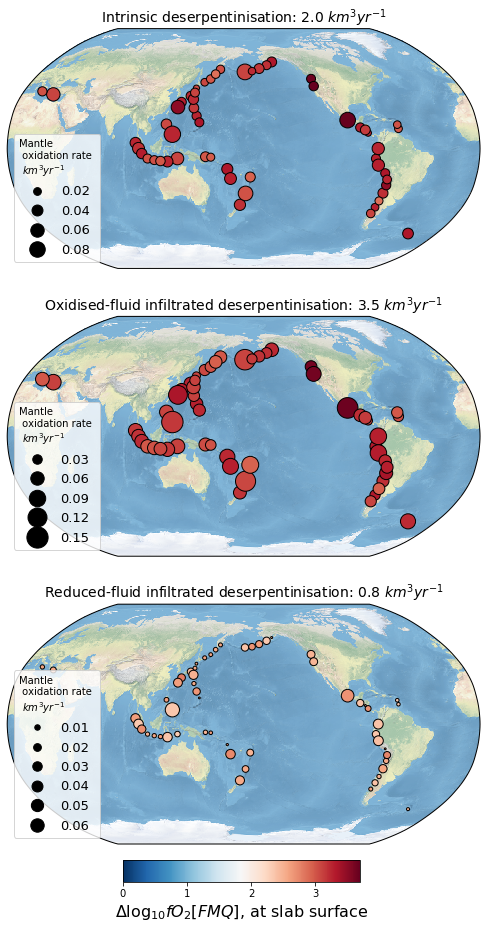

In [23]:
models      = ['intr','gloss', 'graph']
rates       = [intr, gloss, graph]
model_title = ['Intrinsic deserpentinisation', 
               'Oxidised-fluid infiltrated deserpentinisation', 
               'Reduced-fluid infiltrated deserpentinisation']

nrows, ncols = 3, 1

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=-180, globe=None)},
                        figsize=(11,15))
axs=axs.flatten()

kw = dict(prop="sizes", num=5, fmt="{x:.2f}",
          func=lambda s: s/3000)

cm = plt.cm.get_cmap('RdBu_r')

#Loop over all of the models
for i,model in enumerate(models):
    
        # 
        axs[i].stock_img()

        # Scatter plot
        cs=axs[i].scatter(x = SZ_DB['Lon (°)'].values,
                          y = SZ_DB['Lat (°)'].values,
                          c = SZ_DB['deltafO2_' + models[i]].values,
                          vmin=0, vmax=3.7, 
                          s = 3000*SZ_DB['oxidation rate (km3/yr)_' + models[i]].values,
                          edgecolor='black',
                          cmap=cm, 
                          transform=ccrs.PlateCarree())

        # Title each subplot with the name of the model
        axs[i].set_title(model_title[i] + ': ' + str(round(rates[i],1)*factor.round(1)) + ' $km^3yr^{-1}$',
                        fontsize = '14')
        axs[i].legend(*cs.legend_elements(**kw), 
                      loc="lower left", title="Mantle \n oxidation rate \n $km^3yr^{-1}$",
                      fontsize = '13') 

cbar_ax = fig.add_axes([0.36, 0.09, 0.3, 0.02])

cbar = plt.colorbar(cs, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('$\Delta \log_{10} fO_2[FMQ]$, at slab surface', fontsize = '16')

plt.show()
fig.savefig('Figure_4.pdf')

# Decoupling between $fO_2$ and oxidation capacity between the three models
The global distribution of the oxidation rate shows that the range of $fO_2$ of fluids from the intrinsic and the gloss model are similar but the oxidation rate of the later are doubled. The oxidation capacity of 

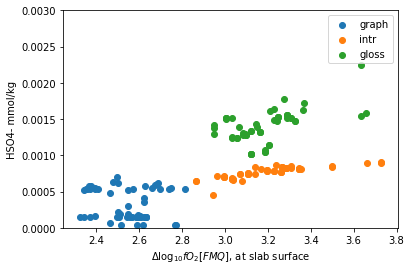

In [24]:
plt.scatter(SZ_DB['deltafO2_graph'],SZ_DB['y_{HSO4-}_graph'], label='graph')
plt.scatter(SZ_DB['deltafO2_intr'], SZ_DB['y_{HSO4-}_intr'],  label='intr')
plt.scatter(SZ_DB['deltafO2_gloss'],SZ_DB['y_{HSO4-}_gloss'], label='gloss')
plt.xlabel('$\Delta \log_{10} fO_2[FMQ]$, at slab surface')
plt.ylabel('HSO4- mmol/kg')

plt.ylim(0,0.003)
plt.legend()
plt.show()

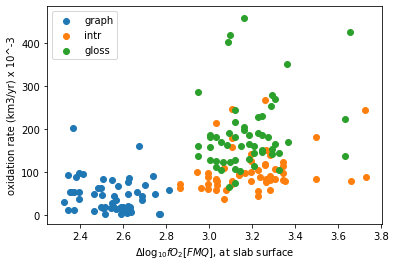

In [25]:
plt.scatter(SZ_DB['deltafO2_graph'],SZ_DB['oxidation rate (km3/yr)_graph']*3000, label='graph')
plt.scatter(SZ_DB['deltafO2_intr'], SZ_DB['oxidation rate (km3/yr)_intr']*3000,  label='intr')
plt.scatter(SZ_DB['deltafO2_gloss'],SZ_DB['oxidation rate (km3/yr)_gloss']*3000, label='gloss')
plt.xlabel('$\Delta \log_{10} fO_2[FMQ]$, at slab surface')
plt.ylabel('oxidation rate (km3/yr) x 10^-3')

#plt.ylim(0,130)
plt.legend()
plt.show()